In [52]:
import tensorflow_hub as hub

from ig_utils import *

# Integrated gradients use cases

### Load model and labels

In [2]:
inception_v1 = tf.keras.Sequential([
    hub.KerasLayer(name='inception_v1', 
                   handle="https://tfhub.dev/google/imagenet/inception_v1/classification/4", 
                   trainable=False),
])

In [3]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

### Read and plot a few new images

In [4]:
# img_name_url {image_name: origin_url}
img_name_url = {
    'Golden Retriever': 'https://storage.googleapis.com/applied-dl/temp/Golden_retriever.jpg',
    'Yellow Labrador Retriever': 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg',
    'Military Uniform (Grace Hopper)': 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg',
    'Military Uniform (General Ulysses S. Grant)': 'https://storage.googleapis.com/applied-dl/temp/General_Ulysses_S._Grant%2C_Union_Army_(6186252896).jpg',
    'Military Uniform (Greek Presidential Guard)': 'https://storage.googleapis.com/applied-dl/temp/Greek_guard_uniforms_1.jpg',
}

In [5]:
# img_name_path {image_name: downloaded_image_local_path}
img_name_path = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_name_url.items()}

In [6]:
# img_name_tensors {image_name: read_image_tensor}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_name_path.items()}

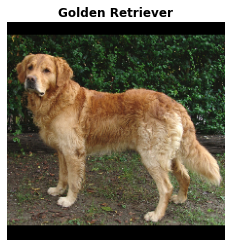

golden retriever: 84.7%
kuvasz: 4.8%
Chesapeake Bay retriever: 1.8%


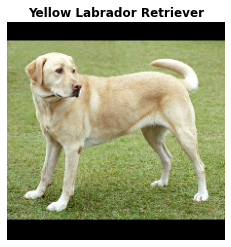

Labrador retriever: 79.7%
golden retriever: 2.7%
Chesapeake Bay retriever: 1.9%


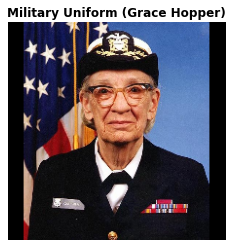

military uniform: 35.5%
Windsor tie: 4.3%
suit: 4.1%


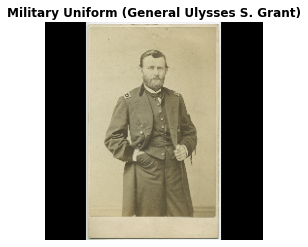

trench coat: 67.3%
suit: 14.2%
military uniform: 3.6%


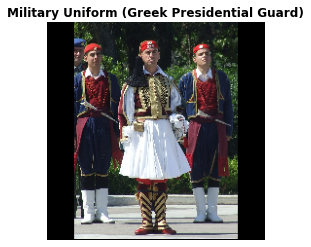

vestment: 15.6%
groom: 3.7%
accordion: 3.2%


In [7]:
for name, img_tensor in img_name_tensors.items():
    plot_img_predictions(model=inception_v1, img_tensor=img_tensor, name=name, labels=imagenet_labels)

### Baselines

In [8]:
name_baseline_tensors = {
    'Baseline Image: Black': tf.zeros(shape=(224, 224, 3)),
    'Baseline Image: White': tf.ones(shape=(224, 224, 3)),
}

### Use case: understanding feature importances

- What is the difference between a Golden Retriever and Labrador Retriever?

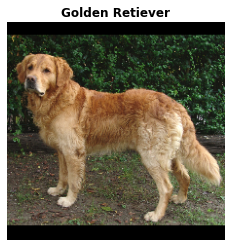

golden retriever: 84.7%
kuvasz: 4.8%
Chesapeake Bay retriever: 1.8%


In [9]:
_ = plot_img_predictions(
    model=inception_v1, 
    img_tensor=img_name_tensors['Golden Retriever'], 
    name='Golden Retiever', 
    labels=imagenet_labels
)

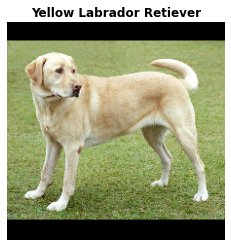

Labrador retriever: 79.7%
golden retriever: 2.7%
Chesapeake Bay retriever: 1.9%


In [10]:
_ = plot_img_predictions(
    model=inception_v1, 
    img_tensor=img_name_tensors['Yellow Labrador Retriever'], 
    name='Yellow Labrador Retiever', 
    labels=imagenet_labels
)

- The model is quite confident about the Golden Retriever in the top image 
- In comparison, the model is relatively less confident about its correct prediction of the Labrador Retriever in the second image and also sees some shades of similarity with the Golden Retriever

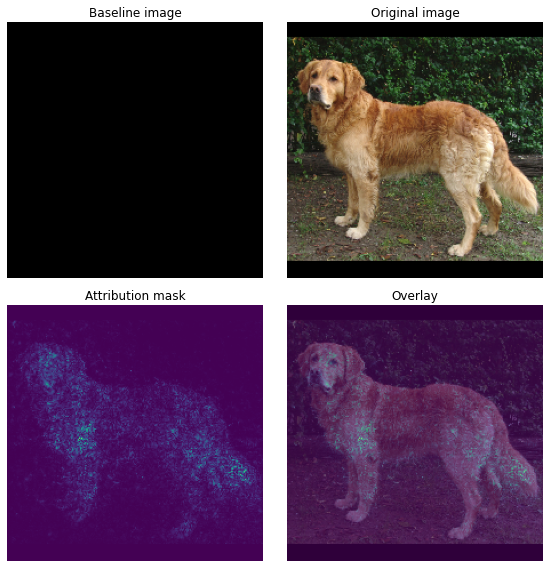

In [13]:
_ = plot_img_attributions(model=inception_v1,
                          image=img_name_tensors['Golden Retriever'],
                          baseline=name_baseline_tensors['Baseline Image: Black'],                       
                          target_class_idx=tf.constant(208),
                          m_steps=tf.constant(1250),
                          cmap=None,
                          overlay_alpha=0.3)

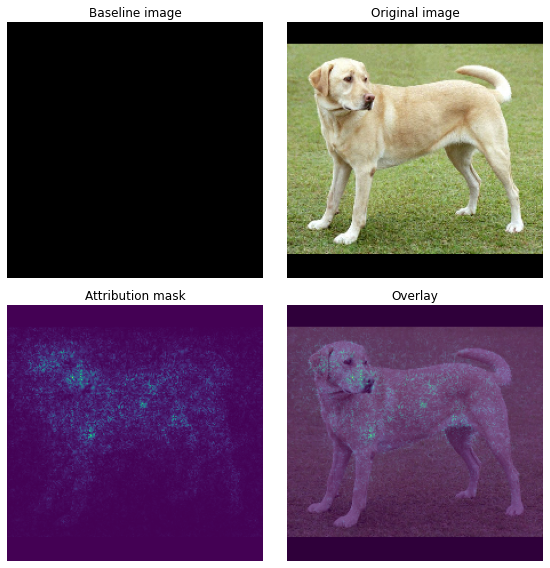

In [14]:
_ = plot_img_attributions(model=inception_v1,
                          image=img_name_tensors['Yellow Labrador Retriever'],
                          baseline=name_baseline_tensors['Baseline Image: Black'],                          
                          target_class_idx=tf.constant(208),
                          m_steps=tf.constant(1250),
                          cmap=None,
                          overlay_alpha=0.3)

- The model uses different features to identify both breeds.
- We can use this to make our model better, for example, by retraining with more pictures of each breed and applying augmentations to the textures and colours of the dogs' coats.

### Use case: debugging data skew

- Training-serving data skew, a difference between performance during training and during model serving.
- Tracking IG feature importances across time (e.g. "next day" splits) and data splits (e.g. train/dev/test splits) allows for meaningful monitoring of train-serving feature drift and skew.

Let's consider an example with military uniforms that change over time and are also geographical location.

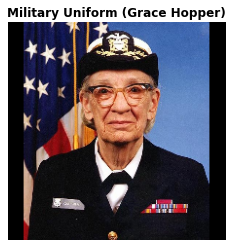

military uniform: 35.5%
Windsor tie: 4.3%
suit: 4.1%


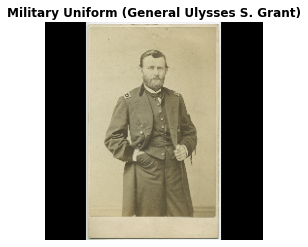

trench coat: 67.3%
suit: 14.2%
military uniform: 3.6%


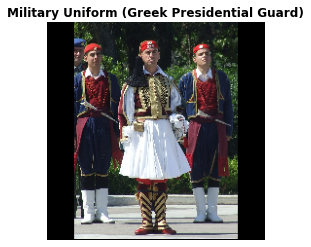

vestment: 15.6%
groom: 3.7%
accordion: 3.2%


In [19]:
military_uniforms = ['Military Uniform (Grace Hopper)',
                     'Military Uniform (General Ulysses S. Grant)',
                     'Military Uniform (Greek Presidential Guard)'] 

for name in military_uniforms:
    plot_img_predictions(inception_v1, img_name_tensors[name], name, imagenet_labels)

We can plot IG for all images and visually inspect them

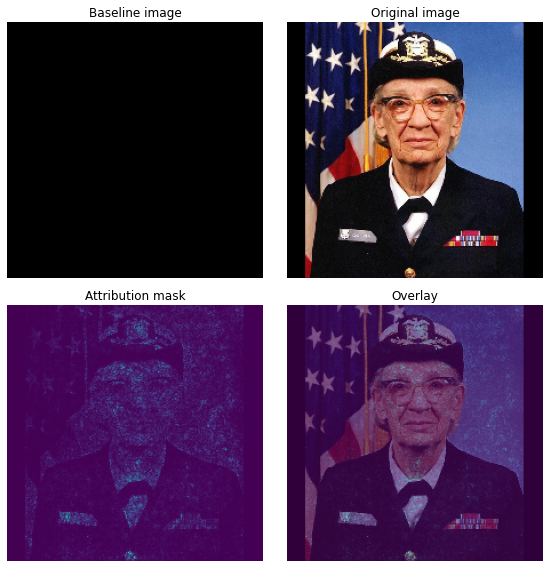

In [23]:
_ = plot_img_attributions(model=inception_v1,
                          image=img_name_tensors['Military Uniform (Grace Hopper)'],
                          baseline=name_baseline_tensors['Baseline Image: Black'],                          
                          target_class_idx=tf.constant(653),
                          m_steps=tf.constant(2000),
                          cmap=None,
                          overlay_alpha=0.3)

**[Grace Hopper](https://en.wikipedia.org/wiki/Grace_Hopper)**

- The model correctly classifies the first image of United States Rear Admiral and Computer Scientist, Grace Hopper, under the class "military uniform" above. 
- You can see that brightest intensity pixels are focused around the shirt colar and tie, military insignia on the jacket and hat, and various pixel areas around her face. 


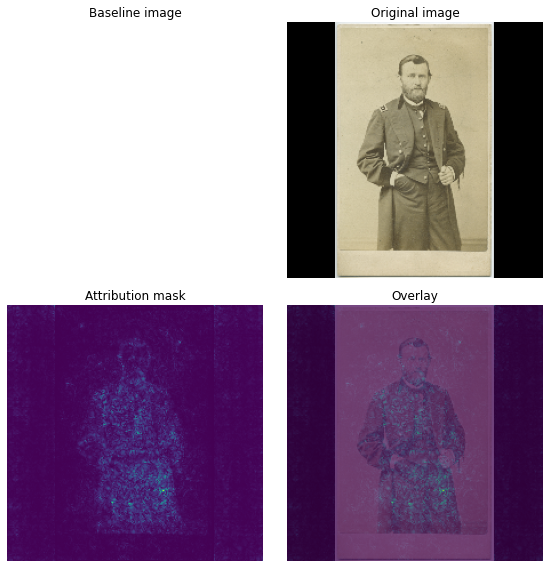

In [25]:
_ = plot_img_attributions(model=inception_v1,
                          image=img_name_tensors['Military Uniform (General Ulysses S. Grant)'],
                          baseline=name_baseline_tensors['Baseline Image: White'],                          
                          target_class_idx=tf.constant(870),
                          m_steps=tf.constant(1500),
                          cmap=None,
                          overlay_alpha=0.3)

**[Ulysses S. Grant](https://en.wikipedia.org/wiki/Ulysses_S._Grant)**

- The model predictions above, you can see not very well as the model incorrectly predicts a trench coat and suit above a military uniform, since the uniform is old.
- Since this is a faded black and white image with prominent darker features, a white baseline is a better choice.
- The model identified the military insignia patch on the right shoulder, face, collar, jacket buttons, and pixels around the edges of the coat. 
- We can improve model performance by adding data augmentation to the input data pipeline to include additional colorless images and image translations as well as additional example images with military coats.

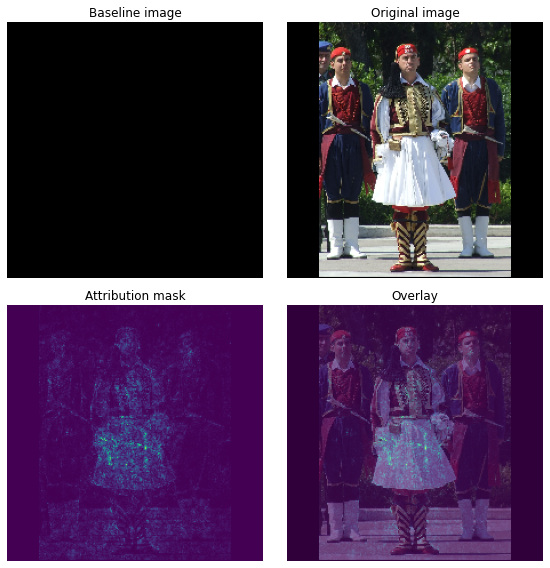

In [26]:
_ = plot_img_attributions(model=inception_v1,
                          image=img_name_tensors['Military Uniform (Greek Presidential Guard)'],
                          baseline=name_baseline_tensors['Baseline Image: Black'],                          
                          target_class_idx=tf.constant(653),
                          m_steps=tf.constant(1500),
                          cmap=None,
                          overlay_alpha=0.3)

**[Greek Presidential Guard](https://en.wikipedia.org/wiki/Presidential_Guard_(Greece))**

- The model incorrectly predicted the image of a Greek Presidential Guard as a vestment with low confidence. 
- There is not enough examples of such uniform in the training set.
- Re-training the model on this more diverse sampling of the input space of Greece military uniforms, in particular those that emphasize military insignia, as well as utilizing weighting strategies during training can help mitigate biased data and further refine model performance and generalization.

### Use case: debugging model performance

When using IG feature attributions for debugging, you are looking for insights into the following questions:

*   Which features are important? 
*   How well does the model's learned features generalize? 
*   Does the model learn "incorrect" or spurious features in the image beyond the true class object?
*   What features did my model miss?
*   Comparing correct and incorrect examples of the same class, what is the difference in the feature attributions?



### Exercise

**Aapply 3 transformations to the "Yellow Labrador Retriever" image and constrast correct and incorrect IG feature attributions to gain insight into the model's limitations.**
- Transformations:
    - rotate the image by 90 degrees
    - flip upside down
    - zoom in range (0.45, 0.45)
- Plot images with class predictions.
- *Separately* calculate IG, using `integrated_gradients` with black baseline and number of steps 1250.
- Plot IG overlayed over a zoomed image, over an original image and one plot with both attribution masks overlayed. Use different `cmap`s for both masks.
- What conclusions about CNNs can you draw from these results?
- What can be done to improve learning?

Hint: use `tf.image.rot90`, `tf.image.flip_up_down`, `tf.keras.prepocessing.image.random_zoom` with default settings and the specified above zoom and `tf.reduce_sum(tf.abs(attributions), axis=-1)` for creating an attribution mask.

In [50]:
rotate90_labrador_retriever_img = tf.image.rot90(img_name_tensors['Yellow Labrador Retriever'])
upsidedown_labrador_retriever_img = tf.image.flip_up_down(img_name_tensors['Yellow Labrador Retriever'])
zoom_labrador_retriever_img = tf.keras.preprocessing.image.random_zoom(x=img_name_tensors['Yellow Labrador Retriever'], 
                                                                       zoom_range=(0.45, 0.45))

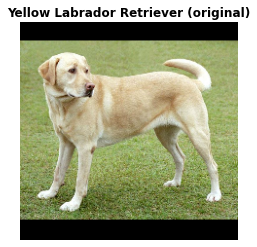

Labrador retriever: 79.7%
golden retriever: 2.7%
Chesapeake Bay retriever: 1.9%


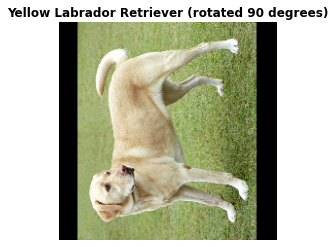

whippet: 20.1%
Italian greyhound: 7.7%
Ibizan hound: 5.3%


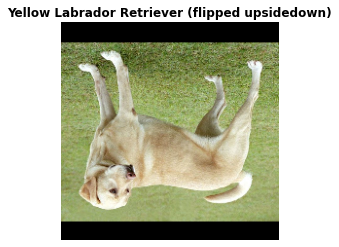

gazelle: 8.9%
Ibizan hound: 8.5%
Weimaraner: 6.1%


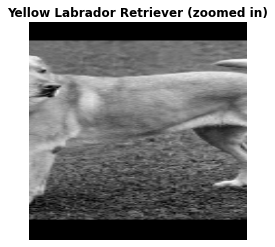

Saluki: 67.8%
Eskimo dog: 5.9%
golden retriever: 4.6%


In [51]:
yellow_labrador_names = [
    'Yellow Labrador Retriever (original)',
    'Yellow Labrador Retriever (rotated 90 degrees)',
    'Yellow Labrador Retriever (flipped upsidedown)',
    'Yellow Labrador Retriever (zoomed in)']
yellow_labrador_tensors = [
    img_name_tensors['Yellow Labrador Retriever'],
    rotate90_labrador_retriever_img, 
    upsidedown_labrador_retriever_img,
    zoom_labrador_retriever_img
]

for name, tensor in zip(yellow_labrador_names, yellow_labrador_tensors):
    plot_img_predictions(inception_v1, tensor, name, imagenet_labels)

**CNNs are not naturally rotationally or scale invariant.**

PLotting IGs will help to gain insight why the model made an error to take corrective action.

In [30]:
labrador_retriever_attributions = integrated_gradients(
    model=inception_v1,
    baseline=name_baseline_tensors['Baseline Image: Black'],
    image=img_name_tensors['Yellow Labrador Retriever'],
    target_class_idx=tf.constant(209),
    m_steps=tf.constant(1250),
)

zoom_labrador_retriever_attributions = integrated_gradients(
    model=inception_v1,
    baseline=name_baseline_tensors['Baseline Image: Black'],
    image=zoom_labrador_retriever_img,
    target_class_idx=tf.constant(209),
    m_steps=tf.constant(1250),
)

Zooming in on the Labrador Retriever image causes the model to incorrectly predict a different dog breed, a [Saluki](https://en.wikipedia.org/wiki/Saluki).
 
We will compare the IG attributions on the incorrect and correct predictions below.

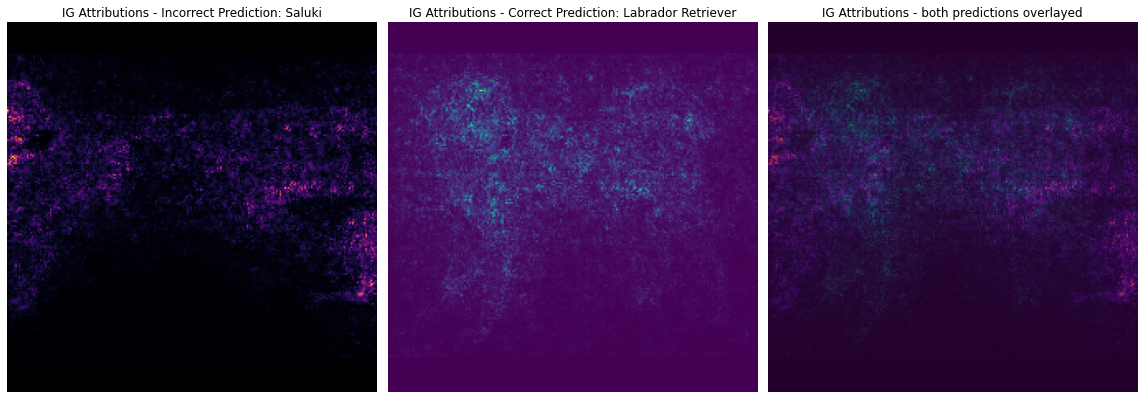

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 12))

axs[0,0].set_title('IG Attributions - Incorrect Prediction: Saluki')
axs[0,0].imshow(tf.reduce_sum(tf.abs(zoom_labrador_retriever_attributions), axis=-1), cmap=plt.cm.inferno)
axs[0,0].axis('off')

axs[0,1].set_title('IG Attributions - Correct Prediction: Labrador Retriever')
axs[0,1].imshow(tf.reduce_sum(tf.abs(labrador_retriever_attributions), axis=-1), cmap=None)
axs[0,1].axis('off')

axs[0,2].set_title('IG Attributions - both predictions overlayed')
axs[0,2].imshow(tf.reduce_sum(tf.abs(zoom_labrador_retriever_attributions), axis=-1), cmap=plt.cm.inferno, alpha=0.99)
axs[0,2].imshow(tf.reduce_sum(tf.abs(labrador_retriever_attributions), axis=-1), cmap=None, alpha=0.5)
axs[0,2].axis('off')

plt.tight_layout();

- Notice the difference in feature attributions between the original and the zoomed pictures.
- You can improve model performance by pursuing strategies such as training data augmentation to make your model more robust to changes in object proportions.
- Check your image preprocessing code if it is the same during training and serving to prevent data skew introduced by zooming or resizing operations.

## Summary

- We concentrated on the concrete use cases for applying IG.
- Disccussed potential problems stemming either from data or model training.
- Look at recommendations for further model improvements.